## MLChem Lab3 Neural Networks
MNIST hand-written digit classification with Convolutional Neural Networks.

### 1. Data Preparation
http://yann.lecun.com/exdb/mnist/

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import os

# Download MNIST dataset (or load the directly if you have already downloaded them previously)
if os.path.exists("./data/MNIST"):
    _dl = False
else:
    _dl = True
    
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
trainset_all = torchvision.datasets.MNIST('./data', train=True, download=_dl, transform=transform)
testset = torchvision.datasets.MNIST('./data', train=False, download=_dl, transform=transform)

samples = []
print("trainset size: ", len(trainset_all))
print("testset size: ", len(testset))

# show information of the first 10 samples in the training dataset
for i, x in enumerate(trainset_all):
    if len(samples) >= 20:
        break
    print("Shape (Channel, X, Y): ", x[0].shape, "    Label: ", x[1])
    samples.append((x[0].squeeze(), x[1]))

trainset size:  60000
testset size:  10000
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  5
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  0
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  4
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  1
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  9
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  2
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  1
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  3
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  1
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  4
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  3
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  5
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  3
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  6
Shape (Channel, X, Y):  torch.Size([1, 28, 28])     Label:  1
Shape (Channel, X, Y):  tor

#### Data Visualization

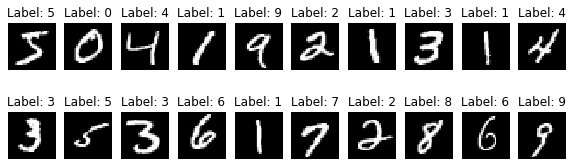

In [2]:
import matplotlib.pyplot as plt

# Visualizing the first 20 samples
plt.figure(figsize=(10, 3))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(samples[i][0], cmap='gray', interpolation='none')
    plt.title("Label: "+str(samples[i][1]))
    plt.axis('off')
plt.show()

#### Train-Validation-Test split

In [3]:
from torch.utils.data import random_split

SEED = 20211031
valid_size = 10000
train_size = len(trainset_all) - valid_size

trainset, valset = random_split(trainset_all, [train_size, valid_size], generator=torch.Generator().manual_seed(SEED))

print("Trainset size: ", len(trainset))
print("Validation set size: ", len(valset))


Trainset size:  50000
Validation set size:  10000


### 2. Model and DataLoader initiation

In [4]:
# hyperparameters
batch_size = 32

# for CNN model (conv2d x2 + fc x2)
conv1c = 16
conv2c = 32
conv1k = 5
conv2k = 3
fc1 = 128
fc2 = 10
batchnorm = True
dropout = 0.1

# for training
lr = 0.001
weight_decay = 1e-5


#### Build DataLoader object
DataLoader is a Class implemented in `torch.utils.data` module, which could load and reorganize your datasets efficiently.

In [5]:
trainloader = DataLoader(trainset, batch_size, shuffle = True, drop_last = True)
valloader = DataLoader(valset, batch_size, shuffle = False, drop_last = False)
testloader = DataLoader(testset, batch_size, shuffle = False, drop_last = False)

#### CNNModel

In [6]:
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

class CNNModel(nn.Module):
    def __init__(self, conv1c, conv2c, conv1k, conv2k, fc1, fc2, batchnorm, dropout):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, conv1c, kernel_size=(conv1k,conv1k))
        self.conv2 = nn.Conv2d(conv1c, conv2c, kernel_size=(conv2k,conv2k))
        
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.dropout = nn.Dropout(p = dropout)
        
        self.batchnorm = batchnorm
        if batchnorm:
            self.bn1 = nn.BatchNorm2d(conv1c)
            self.bn2 = nn.BatchNorm2d(conv2c)
        
        final_size = ((28-conv1k+1)//2-conv2k+1)//2
        self.fc1 = nn.Linear(conv2c*final_size*final_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        
    def forward(self, x):
        # x: [batch_size, 1, 28, 28], assume conv1k=5 and conv2k=3
        out = self.conv1(x) # [batch_size, conv1c, 24, 24]
        out = F.relu(self.pool(out)) # [batch_size, conv1c, 12, 12]
        if self.batchnorm:
            out = self.bn1(out) # [batch_size, conv1c, 12, 12]
        out = self.conv2(out) # [batch_size, conv2c, 10, 10]
        out = F.relu(self.pool(out)) # [batch_size, conv2c, 5, 5]
        
        if self.batchnorm:
            out = self.bn2(out) # [batch_size, conv2c, 5, 5]
        out = out.reshape(out.shape[0], -1) # [batch_size, conv2c*25]
        out = F.relu(self.fc1(out)) # [batch_size, fc1]
        out = self.dropout(out)
        out = F.log_softmax(self.fc2(out), dim=1) # [batch_size, fc2]
        return out
        
model_cnn = CNNModel(conv1c, conv2c, conv1k, conv2k, fc1, fc2, batchnorm, dropout)

#### naive MLP model
We use a naive MLP model as baseline.

In [7]:
class MLP(nn.Module):
    def __init__(self, fc1, fc2, activation, dropout):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        self.fc1 = nn.Linear(28*28, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        
    def forward(self, x):
        # x: [batch_size, 1, 28, 28]
        out = self.activation(self.fc1(x.reshape(x.shape[0], -1))) # [batch_size, fc1]
        out = self.dropout(out)
        out = F.log_softmax(self.fc2(out), dim=1) # [batch_size, fc2]
        return out

model_mlp = MLP(fc1, fc2, activation="sigmoid", dropout=dropout)

### 3. Model training and evaluation
#### Adam Optimizer
https://www.jianshu.com/p/aebcaf8af76e

Adam `torch.optim.Adam` is the most popular adaptive optimizer.

In [8]:
@torch.no_grad()
def evaluation(model, evalloader):
    conf_mat = np.zeros((10, 10))
    model.eval()
    misclassified = []
    predicts = []
    numT = 0
    numF = 0
    for i, x in enumerate(evalloader):
        image, label = x
        pred = torch.argmax(model(image), dim=1)
        _T = torch.sum(pred == label).item()
        numT += _T
        numF += len(label) - _T
        for j in range(len(label)):
            conf_mat[label[j], pred[j]] += 1
            if label[j] != pred[j]:
                misclassified.append((image[j], label[j], pred[j]))
            predicts.append(pred[j])

    model.train()
    return numT/(numT+numF), conf_mat, misclassified, predicts

def fit(model, trainloader, valloader, lr, weight_decay, max_epoch = 10):
    train_batch_losses = []
    val_acc = []
    
    loss_fn = nn.NLLLoss(reduction = "mean")
    optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay) # Using Adam optimizer
    batches_per_epoch = len(trainloader)
    
    for epoch in range(max_epoch):
        epoch_loss = 0
        for i, x in enumerate(trainloader):
            optimizer.zero_grad()
            image, label = x
            pred = model(image)
            loss = loss_fn(pred, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            train_batch_losses.append((epoch*batches_per_epoch+i, loss.item()))
            
            if (i % 200 == 0):
                print("Epoch %d, Batch %d loss: %f"%(epoch, i, loss.item()))
                acc, _cm, _mis, _pred = evaluation(model, valloader)
                val_acc.append((epoch*batches_per_epoch+i, acc))
                print("   Accuracy after epoch %d batch %d: %f"%(epoch, i, acc))
        print("\n##### Epoch %d average loss: "%epoch, epoch_loss/batches_per_epoch, ' #####\n')
    return train_batch_losses, val_acc


print("Training CNN Model.")
model_cnn.train()
train_losses_cnn, val_acc_cnn = fit(model_cnn, trainloader, valloader, lr = lr, weight_decay=weight_decay, max_epoch = 3)

print("Training MLP Model.")
model_mlp.train()
train_losses_mlp, val_acc_mlp = fit(model_mlp, trainloader, valloader, lr = lr, weight_decay=weight_decay, max_epoch = 3)

Training CNN Model.
Epoch 0, Batch 0 loss: 2.262733
   Accuracy after epoch 0 batch 0: 0.237700
Epoch 0, Batch 200 loss: 0.010387
   Accuracy after epoch 0 batch 200: 0.968700
Epoch 0, Batch 400 loss: 0.289804
   Accuracy after epoch 0 batch 400: 0.972800
Epoch 0, Batch 600 loss: 0.001645
   Accuracy after epoch 0 batch 600: 0.980000
Epoch 0, Batch 800 loss: 0.016306
   Accuracy after epoch 0 batch 800: 0.979700
Epoch 0, Batch 1000 loss: 0.139983
   Accuracy after epoch 0 batch 1000: 0.982600
Epoch 0, Batch 1200 loss: 0.028965
   Accuracy after epoch 0 batch 1200: 0.980200
Epoch 0, Batch 1400 loss: 0.006570
   Accuracy after epoch 0 batch 1400: 0.982500

##### Epoch 0 average loss:  0.0993779614469303  #####

Epoch 1, Batch 0 loss: 0.044738
   Accuracy after epoch 1 batch 0: 0.984500
Epoch 1, Batch 200 loss: 0.070075
   Accuracy after epoch 1 batch 200: 0.984400
Epoch 1, Batch 400 loss: 0.014370
   Accuracy after epoch 1 batch 400: 0.986800
Epoch 1, Batch 600 loss: 0.004098
   Accuracy

#### Plot the loss curve
You can visualize the 

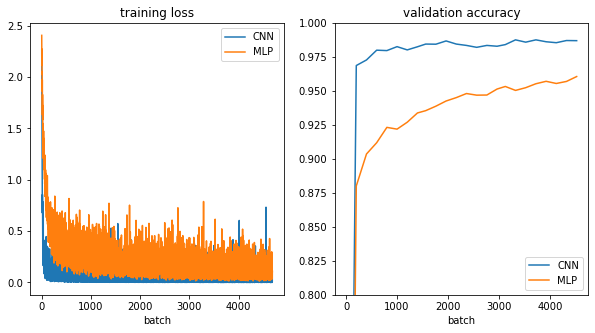

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_x = [i for i, j in train_losses_cnn]
_y_cnn = [j for i, j in train_losses_cnn]
_y_mlp = [j for i, j in train_losses_mlp]

plt.plot(_x, _y_cnn, label="CNN")
plt.plot(_x, _y_mlp, label="MLP")
plt.title("training loss")
plt.xlabel("batch")
plt.legend()

plt.subplot(1,2,2)
_x = [i for i, j in val_acc_cnn]
_y_cnn = [j for i, j in val_acc_cnn]
_y_mlp = [j for i, j in val_acc_mlp]

plt.plot(_x, _y_cnn, label="CNN")
plt.plot(_x, _y_mlp, label="MLP")
plt.ylim(0.8,1.0)
plt.xlabel("batch")
plt.title("validation accuracy")
plt.legend()

plt.show()

#### Model Evaluation

In [10]:
import pandas as pd

CNN_val_acc, CNN_val_cm, CNN_val_mis, CNN_val_pred = evaluation(model_cnn, valloader)
MLP_val_acc, MLP_val_cm, MLP_val_mis, MLP_val_pred = evaluation(model_mlp, valloader)
CNN_val_cm = pd.DataFrame(CNN_val_cm, dtype=int)
MLP_val_cm = pd.DataFrame(MLP_val_cm, dtype=int)

print("CNN Validation Accuracy: ", CNN_val_acc)
print("CNN Validation Confusion Matrix: \n", CNN_val_cm)
print("MLP Validation Accuracy: ", MLP_val_acc)
print("MLP Validation Confusion Matrix: \n", MLP_val_cm)

CNN Validation Accuracy:  0.9873
CNN Validation Confusion Matrix: 
       0     1    2    3    4    5    6     7    8     9
0  1016     0    0    0    0    0    4     0    0     1
1     0  1089    5    1    0    0    0     2    0     0
2     1     1  980    4    1    0    0     9    0     1
3     0     1    5  973    0    1    0     1    1     0
4     1     1    1    0  951    0    2     0    0     8
5     1     0    0    6    0  883    8     0    1     1
6     2     1    0    0    1    2  983     0    0     0
7     0     6    3    0    6    0    0  1040    2     6
8     0     1    2    1    6    1    2     1  926     2
9     0     1    0    1    3    5    0     1    2  1032
MLP Validation Accuracy:  0.9572
MLP Validation Confusion Matrix: 
      0     1    2    3    4    5    6    7    8     9
0  997     1    5    0    0    3    8    1    5     1
1    0  1085    5    1    1    0    0    2    1     2
2    1     2  960    5    8    1    1   11    6     2
3    1     2   17  938    0    7

#### Visualize the misclassified samples for CNN model

Number of Misclassified samples:  127
Visualizing the first 40 misclassified samples


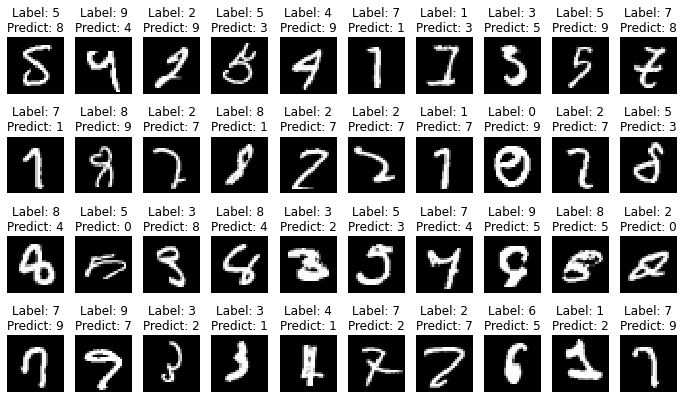

In [11]:
print("Number of Misclassified samples: ", len(CNN_val_mis))
print("Visualizing the first 40 misclassified samples")
plt.figure(figsize=(12,7))
for i in range(40):
    img, label, pred = CNN_val_mis[i]
    img = img.squeeze()
    plt.subplot(4,10,i+1)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Label: "+str(label.item())+"\nPredict: "+str(pred.item()))
    plt.axis('off')
plt.show()

#### Classifying your custom handwritten digits

Mean:  42.99068832397461   Std: 92.2778091430664
My dataset size:  10
Accuracy on custom dataset:  1.0
Visualizing custom samples


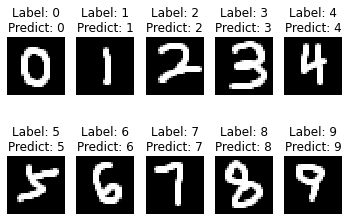

In [12]:
# input
path = "./workdir/handwritten"
images_path = os.listdir(path)
images = []

for i in images_path:
    label = int(i.split('_')[1].split('.')[0])
    image = torchvision.io.read_image(os.path.join(path, i)).float()[0:3,:,:]
    image = image.mean(dim=0).unsqueeze(0)
    images.append((image, label))

_values = torch.concat([i for i,j in images]).reshape(-1)
_mean = _values.mean().item()
_sd = _values.std().item()
print("Mean: ",_mean, "  Std:",_sd)
mytransform = torchvision.transforms.Normalize((_mean), (_sd))
# mytransform = torchvision.transforms.Normalize((0.1307,), (0.3081,))

for i in range(len(images)):
    img = mytransform(images[i][0])
    images[i] = (img, images[i][1])    

from torch.utils.data import Dataset

class mySet(Dataset):
    def __init__(self, images):
        super(mySet, self).__init__()
        self.data = images
    def __getitem__(self, x):
        return self.data[x]
    def __len__(self):
        return len(self.data)

myevalset = mySet(images)
print("My dataset size: ", len(myevalset))

myloader = DataLoader(mySet(images), shuffle=False, drop_last = False, batch_size = batch_size) 
myacc, mycm, mymis, mypred = evaluation(model_cnn, myloader)

print("Accuracy on custom dataset: ", myacc)

print("Visualizing custom samples")
plt.figure()
for i in range(len(myevalset)):
    img, label = myevalset[i]
    pred = mypred[i]
    img = img.squeeze()
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Label: "+str(label)+"\nPredict: "+str(pred.item()))
    plt.axis('off')
plt.show()

### 4. Save and load models
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
#### Save and load model parameters only

In [13]:
os.makedirs("./checkpoints", exist_ok = True)

# save parameters only
torch.save(model_cnn.state_dict(), "./checkpoints/model_cnn.pt")
torch.save(model_mlp.state_dict(), "./checkpoints/model_mlp.pt")

# a new instance of the model
model_cnn = CNNModel(conv1c, conv2c, conv1k, conv2k, fc1, fc2, batchnorm, dropout)
model_mlp = MLP(fc1, fc2, activation="sigmoid", dropout=dropout)


# load parameters
model_cnn.load_state_dict(torch.load("./checkpoints/model_cnn.pt"))
model_mlp.load_state_dict(torch.load("./checkpoints/model_mlp.pt"))

<All keys matched successfully>

#### Save and load general checkpoints

In [14]:
# save a general checkpoint
def save_checkpoint(model, optimizer, epoch, loss, path):
    if optimizer is None:
        optim_state = None
    else:
        optim_state = optimizer.state_dict()
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "optimizer_state_dict": optim_state
    }
    torch.save(checkpoint, path)

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss

# Save checkpoints
save_checkpoint(model_cnn, optimizer=None, epoch=None, loss=None, path="./checkpoints/model_cnn.pt")
save_checkpoint(model_mlp, optimizer=None, epoch=None, loss=None, path="./checkpoints/model_mlp.pt")

# a new instance of the model
model_cnn = CNNModel(conv1c, conv2c, conv1k, conv2k, fc1, fc2, batchnorm, dropout)
model_mlp = MLP(fc1, fc2, activation="sigmoid", dropout=dropout)

# Load checkpoints
model_cnn, optim, epoch, loss = load_checkpoint(model_cnn, optimizer=None, path="./checkpoints/model_cnn.pt")
model_mlp, optim, epoch, loss = load_checkpoint(model_mlp, optimizer=None, path="./checkpoints/model_mlp.pt")